### Requirements:

Tested with opsef003.yml (see attached file)
opsef002 + n2v = opsef003

on a GeForce RTX 2080 with 8GB RAM
on ubuntu/18.04.3 

### adaped from:

https://github.com/MouseLand/cellpose

https://github.com/CellProfiler/CellProfiler

https://github.com/mpicbg-csbd/stardist

https://github.com/scikit-image/scikit-image

https://github.com/VolkerH/unet-nuclei/

Thanks to:

All developer of the above mentioned repositories. 

In [1]:
# basic libs

import os
import sys
import time
import datetime
import inspect
from glob import glob

import tifffile as tif

import cv2 as cv
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections
import math

import pickle

import networkx as nx
%matplotlib inline

# for lif
import readlif
from readlif.reader import LifFile

# skimage
import skimage
from skimage import transform, io, filters, measure, morphology,img_as_float  
from skimage.color import label2rgb,gray2rgb
from skimage.filters import gaussian, rank, threshold_otsu
from skimage.io import imread, imsave
from skimage.measure import label, regionprops, regionprops_table
from skimage.morphology import disk, watershed

# scipy
from scipy.signal import medfilt
from scipy.ndimage import generate_binary_structure, binary_dilation

# for cellpose
from cellpose import models as cp_models
from cellpose import utils as cp_utils
from cellpose import plot, transforms
from cellpose import plot, transforms

# other
import mxnet as mx

# for cluster analysis

from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering

In [2]:
main_folder = os.path.dirname(os.path.abspath(inspect.stack()[0][1]))
import_path = os.path.join(main_folder,"Utils_and_Configs")
if import_path not in sys.path:
    sys.path.append(import_path)

# import from import_path
from Tools_002 import *
from UNet_CP01 import *
from Segmentation_Func_06 import *
from Pre_Post_Process002 import *
from N2V_DataGeneratorTR001 import *
from opsef_core_002 import *

Using TensorFlow backend.
/home/trasse/anaconda3/envs/opsef003/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/trasse/anaconda3/envs/opsef003/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/trasse/anaconda3/envs/opsef003/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/trasse/a

In [3]:
# from https://github.com/mpicbg-csbd/stardist / 3_prediction (2D)
from __future__ import print_function, unicode_literals, absolute_import, division
%config InlineBackend.figure_format = 'retina'
from csbdeep.utils import Path, normalize
from stardist import random_label_cmap, _draw_polygons
from stardist.models import StarDist2D

# other
import pkg_resources
import keras

# We import all our dependencies.
from n2v.models import N2VConfig, N2V
from n2v.utils.n2v_utils import manipulate_val_data
# from n2v.internals.N2V_DataGenerator2 import N2V_DataGenerator2

## Load parameter
the parameter for processing need to be defined in the notebook.
Opsef_Setup_000X
this notebook will print in the end a file_path.
Please cut and paste it below!

In [4]:
file_path = "./Demo_Notebooks/my_runs/Parameter_SDB2018_EpiCells_Run_005.pkl"

infile = open(file_path,'rb')
parameter = pickle.load(infile)
print("Loading processing pipeline from",file_path)
infile.close()
pc,input_def,run_def,initModelSettings = parameter

Loading processing pipeline from ./Demo_Notebooks/my_runs/Parameter_SDB2018_EpiCells_Run_005.pkl


## Process Images

In [5]:
# process for all
    # create subfolder
make_folder_structure(pc,input_def,run_def)

# process for lif
if input_def["input_type"] == ".lif":
    lifobject,input_def = define_lif_pipeline(input_def)
    preprocess_1_for_lif(lifobject,input_def,pc,run_def)
    preprocess_2_for_lif(lifobject,input_def,pc,run_def)
# process for tif
if input_def["input_type"] == ".tif":
    fpath_list = define_tif_pipeline(input_def)
    preprocess_1_for_tif(fpath_list,input_def,pc,run_def)
    preprocess_2_for_tif(fpath_list,input_def,pc,run_def)

# Segment
start_time = datetime.datetime.now()
segment(input_def,pc,run_def,initModelSettings)
end_time = datetime.datetime.now()
time_delta = end_time - start_time
print("The segmentatio took overall:", time_delta)

['/home/trasse/Desktop/MLTestData/SDB2018_EpiCells/tiff/00173.tif', '/home/trasse/Desktop/MLTestData/SDB2018_EpiCells/tiff/00428.tif', '/home/trasse/Desktop/MLTestData/SDB2018_EpiCells/tiff/00206.tif', '/home/trasse/Desktop/MLTestData/SDB2018_EpiCells/tiff/Train_00037.tif', '/home/trasse/Desktop/MLTestData/SDB2018_EpiCells/tiff/00537.tif', '/home/trasse/Desktop/MLTestData/SDB2018_EpiCells/tiff/00641.tif', '/home/trasse/Desktop/MLTestData/SDB2018_EpiCells/tiff/00060.tif', '/home/trasse/Desktop/MLTestData/SDB2018_EpiCells/tiff/00596.tif', '/home/trasse/Desktop/MLTestData/SDB2018_EpiCells/tiff/00419.tif', '/home/trasse/Desktop/MLTestData/SDB2018_EpiCells/tiff/Train_00040.tif', '/home/trasse/Desktop/MLTestData/SDB2018_EpiCells/tiff/00519.tif', '/home/trasse/Desktop/MLTestData/SDB2018_EpiCells/tiff/00180.tif', '/home/trasse/Desktop/MLTestData/SDB2018_EpiCells/tiff/00170.tif', '/home/trasse/Desktop/MLTestData/SDB2018_EpiCells/tiff/00066.tif', '/home/trasse/Desktop/MLTestData/SDB2018_EpiCells

Saving.. /home/trasse/Desktop/MLTestData/SDB2018_EpiCells/Processed_005/00_InputRaw/CleanSum_000_00125.tif
Saving.. /home/trasse/Desktop/MLTestData/SDB2018_EpiCells/Processed_005/01_Input/Input_000_00125.tif
Saving.. /home/trasse/Desktop/MLTestData/SDB2018_EpiCells/Processed_005/00_InputRaw/CleanSum_000_00631.tif
Saving.. /home/trasse/Desktop/MLTestData/SDB2018_EpiCells/Processed_005/01_Input/Input_000_00631.tif
run_now StarDist
Run StarDist SD_2D_dsb2018
Run_SD_ StarDist
Loading network weights from 'weights_last.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.417819, nms_thresh=0.5.
Model_keys dict_keys(['SD_2D_dsb2018'])
Running now:  ['RGBInput_000_00537.tif', 'RGBInput_000_00060.tif']
Saving.. /home/trasse/Desktop/MLTestData/SDB2018_EpiCells/Processed_005/02_SegMasks/000_SD_Mask_0_RGBInput_000_00537.tif
Saving.. /home/trasse/Desktop/MLTestData/SDB2018_EpiCells/Processed_005/03_SegOverlays/000_SD_MaskOutline_0_RGBInput_000_00537.tif
(1024, 1024, 

## Export annditional channel & Quantify Results

In [6]:
if pc["Export_to_CSV"]:
    all_combined = [] # used for quantifications of more than one intensity channel
    # get a list of the masks that were produced by segmentation
    mask_files = glob(os.path.join(input_def["root"],"Processed_{}".format(run_def["run_ID"]),pc["sub_f"][2])+"/*.tif")
    mask_to_img_dic, mask_to_8bitimg_dic = make_mask_to_img_dic(mask_files,pc,input_def,run_def,0,pc["Intensity_Ch"])

In [7]:
if pc["toFiji"]:
    if not pc["Export_to_CSV"]:
        mask_files = glob(os.path.join(input_def["root"],"Processed_{}".format(run_def["run_ID"]),pc["sub_f"][2])+"/*.tif")
        mask_to_img_dic, mask_to_8bitimg_dic = make_mask_to_img_dic(mask_files,pc,input_def,run_def,0,pc["Intensity_Ch"])
    root_plus = os.path.join(input_def["root"],"Processed_{}".format(run_def["run_ID"]))
    txt_fn = os.path.join(root_plus,pc["sub_f"][10],"FilePairList_{}_{}.txt".format(input_def["dataset"],run_def["run_ID"]))
    with open(txt_fn,"w") as f:
        for mask_fn,image_fn in mask_to_8bitimg_dic.items():
            f.write("{};{}{}".format(image_fn.replace(root_plus,""),mask_fn.replace(input_def["root"],""),"\n"))
    f.close()

In [8]:
# export additional channel
if pc["export_another_channel"]:
    exported_file_list = export_second_channel_for_mask(lifobject,pc,input_def,run_def)

In [9]:
# optional in case segmentation results shall be filtered by a mask:
if pc["create_filter_mask_from_channel"]:
    # create new masks (by thresolding the additional input) and extract their names
    new_mask_fn_list = create_mask_from_add_ch(exported_file_list,input_def["root"],pc["sub_f"],run_def["run_ID"],run_def["para_mp"])
    # make a dic that has the segmentation output mask name as key, the name of the threshold mask as value
    pair_dic = make_pair_second_mask_simple(mask_files,new_mask_fn_list)
    # create new seqmentation masks per class and return a list of file_names
    class1_to_img_dic,class2_to_img_dic = split_by_mask(input_def["root"],run_def["run_ID"],pc["sub_f"],pair_dic,mask_to_8bitimg_dic,mask_to_img_dic)

## Export results

In [10]:
# quantify original mask
if pc["Export_to_CSV"]:
    all_combined.append(results_to_csv(mask_to_img_dic,pc["get_property"],input_def["root"],pc["sub_f"],run_def["run_ID"],4,"All_Main",input_def["subset"])) # 4 is the main result folder
    if pc["plot_head_main"]:
        all_combined[0].head()
            
if pc["create_filter_mask_from_channel"]:
    # quantify class1 masks
    results_to_csv(class1_to_img_dic,pc["get_property"],input_def["root"],pc["sub_f"],run_def["run_ID"],9,"Class00",input_def["post_subset"]) # 9 is the classified result folder
    # quantify class2 masks
    results_to_csv(class2_to_img_dic,pc["get_property"],input_def["root"],pc["sub_f"],run_def["run_ID"],9,"Class01",input_def["post_subset"]) # 9 is the classified result folder

In [11]:
if pc["Quantify_2ndCh"]:
    mask_to_img_dic, mask_to_8bitimg_dic = make_mask_to_img_dic(mask_files,pc,input_def,run_def,5,pc["Intensity_2ndCh"])
    all_combined.append(results_to_csv(mask_to_img_dic,pc["get_property"],input_def["root"],pc["sub_f"],run_def["run_ID"],4,"All_2nd",input_def["subset"]))
    if pc["merge_results"]:
        result_summary = merge_intensity_results(all_combined,input_def,pc["sub_f"],run_def,4)
        if pc["plot_merged"]:
            result_summary.head()
else:
    if pc["Export_to_CSV"]:
        result_summary = all_combined[0]

## AddOn 1: Basic plotting of results

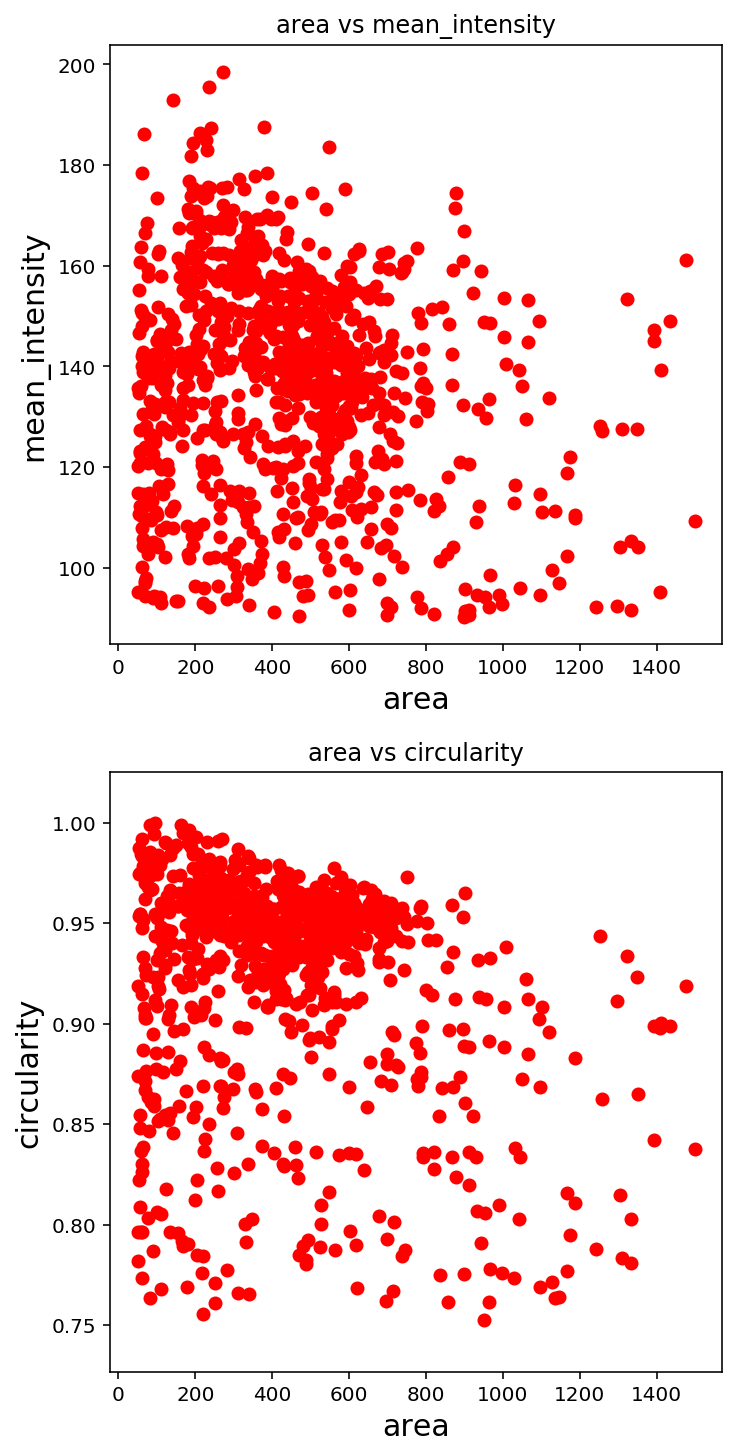

In [12]:
if pc["Plot_Results"]:
    fig, axs = plt.subplots(len(pc["Plot_xy"]), 1, figsize=(5, 5*len(pc["Plot_xy"])), constrained_layout=True)
    for i in range(0,len(pc["Plot_xy"])):
        axs[i].scatter(result_summary[pc["Plot_xy"][i][0]],result_summary[pc["Plot_xy"][i][1]], c="red")
        axs[i].set_title('{} vs {}'.format(*pc["Plot_xy"][i]))
        axs[i].set_xlabel(pc["Plot_xy"][i][0],fontsize=15)
        axs[i].set_ylabel(pc["Plot_xy"][i][1],fontsize=15)

## AddOn 2: Do PCA and TSNE

### Example pipeline auto-clustering

In [13]:
if pc["Cluster_How"] == "Auto":
# get data for PCA / TSNE
    df_for_tsne_list = extract_values_for_TSNE_PCA(input_def["root"],run_def["run_ID"],pc["sub_f"],4,pc["include_in_tsne"])
# get cluster
    data = df_for_tsne_list[0].values
    auto_clustering = AgglomerativeClustering(linkage=pc["link_method"], n_clusters=pc["cluster_expected"]).fit(data)
# do analysis
    result_tsne = TSNE(learning_rate=pc["tSNE_learning_rate"]).fit_transform(data)
    result_pca = PCA().fit_transform(data)
# display results
    fig, axs = plt.subplots(2, 1, figsize=(10, 20), constrained_layout=True)
    axs[0].scatter(result_tsne[:, 0], result_tsne[:, 1], c=auto_clustering.labels_)
    axs[0].set_title('tSNE')
    axs[1].scatter(result_pca[:, 0], result_pca[:, 1], c=auto_clustering.labels_)
    axs[1].set_title('PCA')    

### Example pipeline mask-clustering

In [14]:
# get data for PCA / TSNE
if pc["Cluster_How"] == "Mask":
    df_for_tsne_list_by_class = extract_values_for_TSNE_PCA(input_def["root"],run_def["run_ID"],pc["sub_f"],9,pc["include_in_tsne"])
    fused_df = pd.concat(df_for_tsne_list_by_class,axis = 0,join="outer")
    data_by_class = fused_df.values
    class_def_by_mask = [0 for x in range (0,df_for_tsne_list_by_class[0].shape[0])] + [1 for x in range (0,df_for_tsne_list_by_class[1].shape[0])]
# do analysis
    result_tsne_by_class = TSNE(learning_rate=pc["tSNE_learning_rate"]).fit_transform(data_by_class)
    result_pca_by_class = PCA().fit_transform(data_by_class)
# display results
    fig, axs = plt.subplots(2, 1, figsize=(10, 20), constrained_layout=True)
    axs[0].scatter(result_tsne_by_class[:, 0], result_tsne_by_class[:, 1], c=class_def_by_mask)
    axs[0].set_title('tSNE')
    axs[1].scatter(result_pca_by_class[:, 0], result_pca_by_class[:, 1], c=class_def_by_mask)
    axs[1].set_title('PCA')

## Results

In [15]:
print("Processing completed sucessfully !\n")
print("All results have been saved in this folder: \n")
print(os.path.join(input_def["root"],"Processed_{}".format(run_def["run_ID"])))

Processing completed sucessfully !

All results have been saved in this folder: 

/home/trasse/Desktop/MLTestData/SDB2018_EpiCells/Processed_005
